In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
%matplotlib inline
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings('ignore')
pd.pandas.set_option('display.max_columns',None)

In [3]:
#Train data
df_train=pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')

df_train.head()
#Test data
df_test=pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')

df_test.head()
print(f'Shape of train dataset:\n{df_train.shape}')
print(f'Shape of test dataset:\n{df_test.shape}')

Shape of train dataset:
(1460, 81)
Shape of test dataset:
(1459, 80)


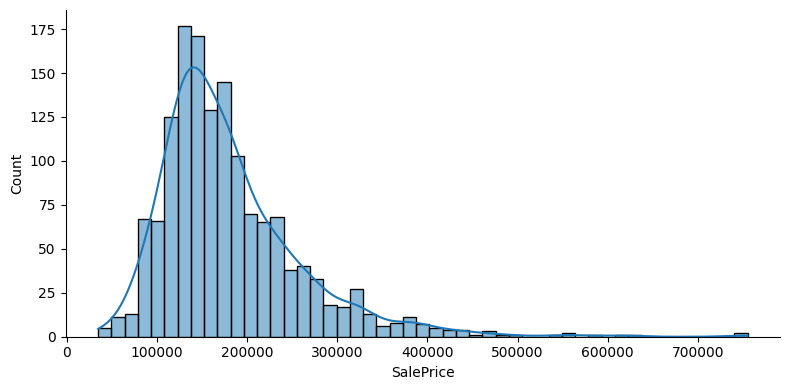

In [4]:
sns.displot(x=df_train['SalePrice'], kde=True, height=4, aspect=2)


**Observation: The dependent feature ‘SalePrice’ is right-skewed. We will later have to perform a log-normal transformation on this feature. When the dependent feature 'SalePrice' is right-skewed, it indicates that there are relatively few very high-priced properties in comparison to the majority of the properties which have lower prices. This kind of skewness can make it challenging to model the data effectively because it violates some assumptions of linear regression and other statistical techniques.**

In [5]:
# find outliers for all the numerical dataset (before handling missing values)
numerical_df = df_train.select_dtypes(exclude='object')
numerical_df = numerical_df.drop('Id', axis=1)


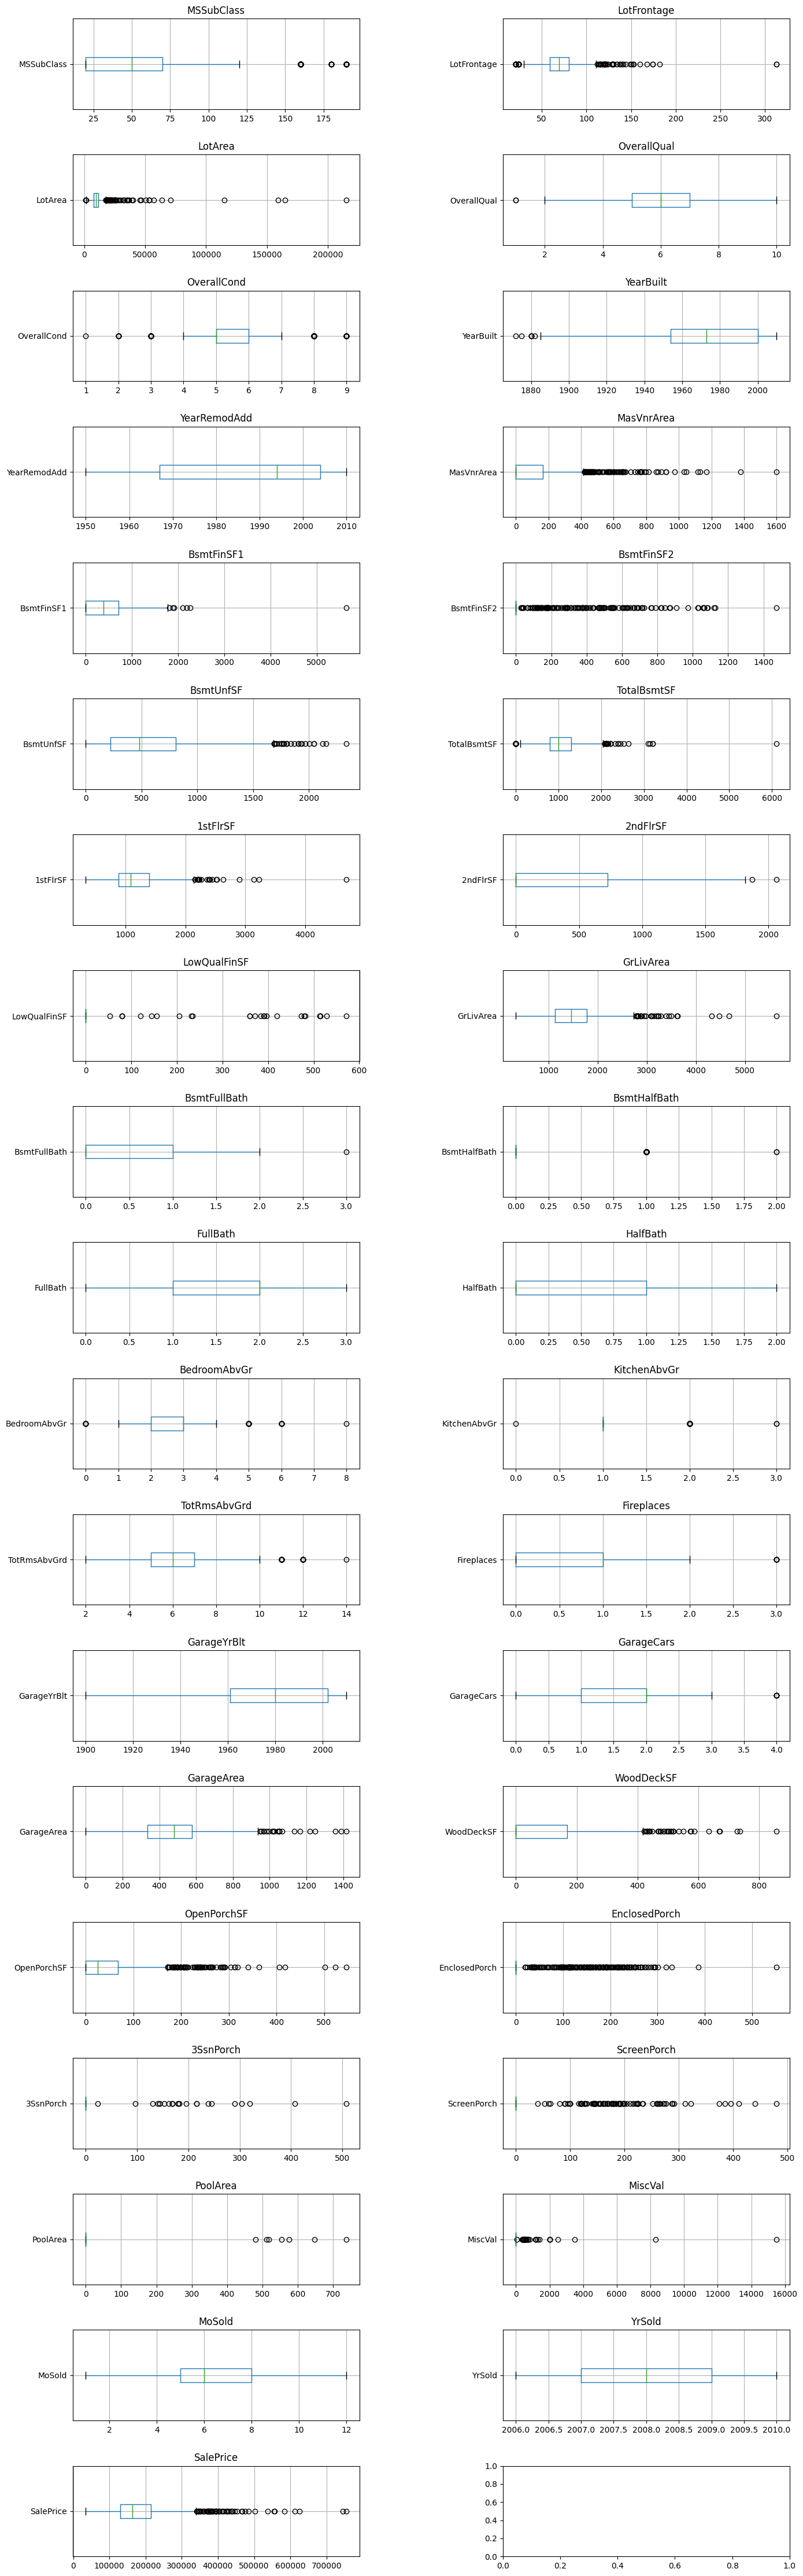

In [6]:
# for column in numerical_df:
#     plt.figure(figsize=(16, 3))
#     sns.boxplot(x=numerical_df[column])

# Define the number of columns for subplots
num_cols = 2

# Calculate the number of rows needed
num_rows = (len(numerical_df.columns) + num_cols - 1) // num_cols

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, 3*num_rows))
plt.subplots_adjust(wspace=0.5, hspace=0.5)

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot boxplots for each numerical column
for i, column in enumerate(numerical_df.columns):
    numerical_df.boxplot(column=column, ax=axes[i], vert=False)
    axes[i].set_title(column)

In [7]:
df_merged = pd.concat([df_test.assign(ind='test'), df_train.assign(ind='train')])
df_merged.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,ind,SalePrice
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,NaN,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,test,NaN
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,test,NaN
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,NaN,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,test,NaN
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal,test,NaN
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,NaN,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal,test,NaN


In [8]:
df_merged.shape

(2919, 82)

In [11]:
def get_cols_with_missing_values(DataFrame):
    missing_na_columns = DataFrame.isna().sum()
    return missing_na_columns[missing_na_columns>0]
print(get_cols_with_missing_values(df_merged))

MSZoning           4
LotFrontage      486
Alley           2721
Utilities          2
Exterior1st        1
Exterior2nd        1
MasVnrType      1766
MasVnrArea        23
BsmtQual          81
BsmtCond          82
BsmtExposure      82
BsmtFinType1      79
BsmtFinSF1         1
BsmtFinType2      80
BsmtFinSF2         1
BsmtUnfSF          1
TotalBsmtSF        1
Electrical         1
BsmtFullBath       2
BsmtHalfBath       2
KitchenQual        1
Functional         2
FireplaceQu     1420
GarageType       157
GarageYrBlt      159
GarageFinish     159
GarageCars         1
GarageArea         1
GarageQual       159
GarageCond       159
PoolQC          2909
Fence           2348
MiscFeature     2814
SaleType           1
SalePrice       1459
dtype: int64


In [14]:
feature_rating_qual = [col for col in df_merged.columns if 'Qual' in col and df_merged[col].dtypes == 'object']
feature_rating_qual

['ExterQual', 'BsmtQual', 'KitchenQual', 'GarageQual']

In [21]:
feature_rating_cond = [col for col in df_merged.columns if 'Cond' in col and col not in ['Condition1', 'Condition2', 'SaleCondition'] and df_merged[col].dtypes == 'object']
feature_rating_cond

['ExterCond', 'BsmtCond', 'GarageCond']

In [24]:
feature_rating_qu = list(filter(lambda x: 'Qu' in x and df_merged[x].dtypes == 'object' and x not in feature_rating_qual, df_merged.columns))
feature_rating_qu

['FireplaceQu']

In [25]:
feature_rating_qc = list(filter(lambda x: 'QC' in x and df_merged[x].dtypes == 'object', df_merged.columns))
feature_rating_qc

['HeatingQC', 'PoolQC']

In [27]:
cat_feature_with_rating = feature_rating_qual + feature_rating_cond + feature_rating_qu + feature_rating_qc
cat_feature_with_rating

['ExterQual',
 'BsmtQual',
 'KitchenQual',
 'GarageQual',
 'ExterCond',
 'BsmtCond',
 'GarageCond',
 'FireplaceQu',
 'HeatingQC',
 'PoolQC']

In [29]:
cat_feature_with_legit_na = ['Alley', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'GarageType', 'GarageFinish', 'Fence', 'MiscFeature']
df_merged[cat_feature_with_legit_na].head()

,Alley,BsmtExposure,BsmtFinType1,BsmtFinType2,GarageType,GarageFinish,Fence,MiscFeature
0,NaN,No,Rec,LwQ,Attchd,Unf,MnPrv,NaN
1,NaN,No,ALQ,Unf,Attchd,Unf,NaN,Gar2
2,NaN,No,GLQ,Unf,Attchd,Fin,MnPrv,NaN
3,NaN,No,GLQ,Unf,Attchd,Fin,NaN,NaN
4,NaN,No,ALQ,Unf,Attchd,RFn,NaN,NaN


In [31]:
ordinal_cat_feature = cat_feature_with_rating + cat_feature_with_legit_na
ordinal_cat_feature

['ExterQual',
 'BsmtQual',
 'KitchenQual',
 'GarageQual',
 'ExterCond',
 'BsmtCond',
 'GarageCond',
 'FireplaceQu',
 'HeatingQC',
 'PoolQC',
 'Alley',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'GarageType',
 'GarageFinish',
 'Fence',
 'MiscFeature']

In [34]:
df_merged[ordinal_cat_feature] = df_merged[ordinal_cat_feature].fillna('Missing')
df_merged.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,ind,SalePrice
0,1461,20,RH,80.0,11622,Pave,Missing,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,NaN,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,Missing,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,Missing,MnPrv,Missing,0,6,2010,WD,Normal,test,NaN
1,1462,20,RL,81.0,14267,Pave,Missing,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,Missing,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,Missing,Missing,Gar2,12500,6,2010,WD,Normal,test,NaN
2,1463,60,RL,74.0,13830,Pave,Missing,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,NaN,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,Missing,MnPrv,Missing,0,3,2010,WD,Normal,test,NaN
3,1464,60,RL,78.0,9978,Pave,Missing,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,Missing,Missing,Missing,0,6,2010,WD,Normal,test,NaN
4,1465,120,RL,43.0,5005,Pave,Missing,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,NaN,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,Missing,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,Missing,Missing,Missing,0,1,2010,WD,Normal,test,NaN


In [37]:
categorical_cols = [name for name in df_merged.columns if df_merged[name].dtypes == 'object' and name != 'ind']
remain_cat_columns = [col for col in df_merged.columns if col not in ordinal_cat_feature]
#Handling Missing Values in Categorical features by replacing them with the feature mode value


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,Foundation,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Functional,Fireplaces,GarageYrBlt,GarageCars,GarageArea,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,ind,SalePrice
0,1461,20,RH,80.0,11622,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,NaN,0.0,CBlock,468.0,144.0,270.0,882.0,GasA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,5,Typ,0,1961.0,1.0,730.0,Y,140,0,0,0,120,0,0,6,2010,WD,Normal,test,NaN
1,1462,20,RL,81.0,14267,Pave,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,CBlock,923.0,0.0,406.0,1329.0,GasA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,6,Typ,0,1958.0,1.0,312.0,Y,393,36,0,0,0,0,12500,6,2010,WD,Normal,test,NaN
2,1463,60,RL,74.0,13830,Pave,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,NaN,0.0,PConc,791.0,0.0,137.0,928.0,GasA,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,6,Typ,1,1997.0,2.0,482.0,Y,212,34,0,0,0,0,0,3,2010,WD,Normal,test,NaN
3,1464,60,RL,78.0,9978,Pave,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,PConc,602.0,0.0,324.0,926.0,GasA,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,7,Typ,1,1998.0,2.0,470.0,Y,360,36,0,0,0,0,0,6,2010,WD,Normal,test,NaN
4,1465,120,RL,43.0,5005,Pave,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,NaN,0.0,PConc,263.0,0.0,1017.0,1280.0,GasA,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,5,Typ,0,1992.0,2.0,506.0,Y,0,82,0,0,144,0,0,1,2010,WD,Normal,test,NaN


In [38]:
for col in remain_cat_columns:
    df_merged[col] = df_merged[col].fillna(df_merged[col].mode()[0])

In [39]:
df_merged[remain_cat_columns].isna().sum()

Id               0
MSSubClass       0
MSZoning         0
LotFrontage      0
LotArea          0
                ..
YrSold           0
SaleType         0
SaleCondition    0
ind              0
SalePrice        0
Length: 64, dtype: int64

**. Impute missing numerical features[](http://)**

In [55]:
numerical_cols = [col for col in df_merged.columns if df_merged[col].dtypes != 'object']
# numerical_cols = df_merged.select_dtypes(exclude='object')
# numerical_cols.info()
df_merged[numerical_cols]=df_merged[numerical_cols].fillna(df_merged[numerical_cols].mean())
df_merged[numerical_cols].describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000
mean,1460.000000,57.137718,67.756423,10168.114080,6.089072,5.564577,1971.312778,1984.264474,101.396026,441.272011,49.565262,560.579993,1051.417266,1159.581706,336.483727,4.694416,1500.759849,0.429599,0.061322,1.568003,0.380267,2.860226,1.044536,6.451524,0.597122,1979.577938,1.766701,472.712573,93.709832,47.486811,23.098321,2.602261,16.062350,2.251799,50.825968,6.213087,2007.792737,160467.607400
std,842.787043,42.517628,21.592540,7886.996359,1.409947,1.113131,30.291442,20.894344,178.854579,455.606014,169.179104,439.590889,441.120498,392.362079,428.701456,46.396825,506.051045,0.524676,0.245608,0.552969,0.502872,0.822693,0.214462,1.569379,0.646129,25.605659,0.761506,215.535686,126.526589,67.575493,64.244246,25.188169,56.184365,35.663946,567.402211,2.714762,1.314964,59785.743435
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1895.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,730.500000,20.000000,60.000000,7478.000000,5.000000,5.000000,1953.500000,1965.000000,0.000000,0.000000,0.000000,220.000000,793.000000,876.000000,0.000000,0.000000,1126.000000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.500000,1.000000,320.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000,140000.000000
50%,1460.000000,50.000000,63.000000,9453.000000,6.000000,5.000000,1973.000000,1993.000000,0.000000,368.000000,0.000000,467.000000,989.000000,1082.000000,0.000000,0.000000,1444.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1984.000000,2.000000,480.000000,0.000000,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,140000.000000
75%,2189.500000,70.000000,78.000000,11570.000000,7.000000,6.000000,2001.000000,2004.000000,163.500000,733.000000,0.000000,805.000000,1302.000000,1387.500000,704.000000,0.000000,1743.500000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2003.000000,2.000000,576.000000,168.000000,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,163000.000000
max,2919.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1526.000000,2336.000000,6110.000000,5095.000000,2065.000000,1064.000000,5642.000000,3.000000,2.000000,4.000000,2.000000,8.000000,3.000000,15.000000,4.000000,2207.000000,5.000000,1488.000000,1424.000000,742.000000,1012.000000,508.000000,576.000000,800.000000,17000.000000,12.000000,2010.000000,755000.000000
